# Laboratory work 9
## Title: Development of tracking filter of a moving object when measurements and motion model are in different coordinate systems
## Group 1: Viktor Liviniuk, Alina Liviniuk
## Skoltech
## 2017

The objective of this laboratory work is to develop a tracking filter of a moving object  when measurements and motion model are in different coordinate systems. This problem is typical for radio navigation systems.

## Generation of trajectory and measurements (pseudo)

Generate a true trajectory. <br>
Object moves uniformly. Trajectory is deterministic.

In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
def generate_tr(x0,Vx0,y0,Vy0):
    x = np.zeros(N)
    y = np.zeros(N)
    Vx = np.zeros(N)
    Vy = np.zeros(N)
    # initial conditions
    x[0] = x0
    y[0] = y0
    Vx[0] = Vx0
    Vy[0] = Vy0
    for i in range(1, N):
        x[i] = x[i - 1] + Vx[i - 1] * T
        y[i] = y[i - 1] + Vy[i - 1] * T
        Vx[i] = Vx[i - 1]
        Vy[i] = Vy[i - 1]
    return [x,Vx,y,Vy]

In [3]:
N = 26
T = 2

[x,Vx,y,Vy] = generate_tr(10000,-50,10000,-45)

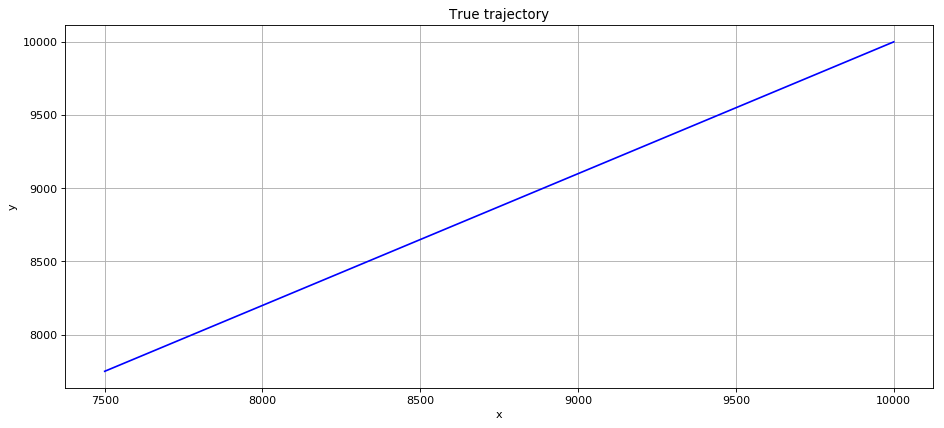

In [4]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(x, y, "b-")
plt.title('True trajectory')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
# Create time list
Time = range(0, N * T, T)

Change to polar coordinate system. 

In [6]:
from math import atan
# Generate true values of range D and azimuth b 
def change_to_polar(x,y):
    N = len(x)
    D = np.zeros(N)
    b = np.zeros(N)
    for i in range(N):
        D[i] = sqrt(x[i]**2 + y[i]**2)
        b[i] = atan(x[i] / y[i])
    return [D, b]

In [7]:
[D, b] = change_to_polar(x,y)

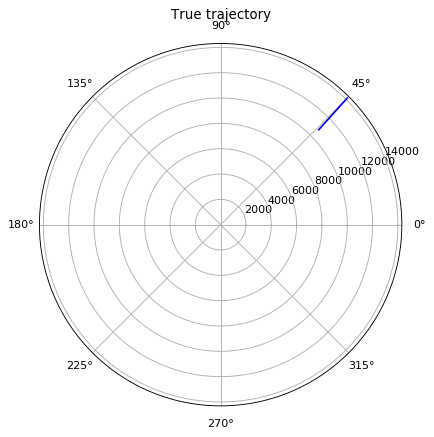

In [8]:
# Plot
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(b, D, "b-")
plt.title('True trajectory')
plt.show()

Generate measurements of the coordinate

In [9]:
sigmaD = 20
sigmab = 0.02

In [10]:
# Generate measurements Dm and bm of range 𝐷 and azimuth b
def generate_measurements(N, sigmaD, sigmab):
    etaD = np.random.normal(0, sigmaD, N)
    etab = np.random.normal(0, sigmab, N)

    Dm = np.zeros(N)
    bm = np.zeros(N)
    for i in range(N):
        Dm[i] = D[i] + etaD[i]
        bm[i] = b[i] + etab[i]
        
    return [Dm, bm]

In [11]:
[Dm, bm] = generate_measurements(N, sigmaD, sigmab)

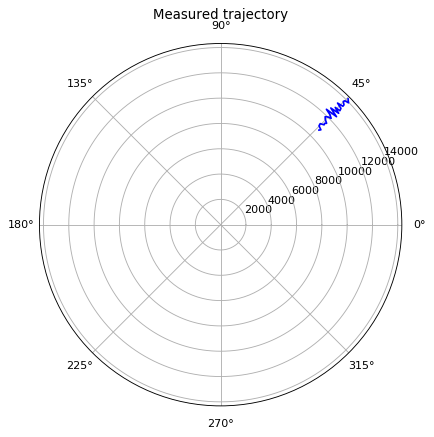

In [12]:
# Plot
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(bm, Dm, "b-")
plt.title('Measured trajectory')
# plt.ylim(9000,14000)
plt.show()

Transform measurements polar coordinates to Cartesian ones and get pseudo-measurements xpm and ypm of coordinates.

In [13]:
def polar_to_cartesian(Dm, bm):
    N = len(Dm)
    xpm = np.zeros(N)
    ypm = np.zeros(N)
    for i in range(N):
        xpm[i] = Dm[i] * np.sin(bm[i])
        ypm[i] = Dm[i] * np.cos(bm[i])
    return [xpm, ypm]

In [14]:
[xpm, ypm] = polar_to_cartesian(Dm, bm)

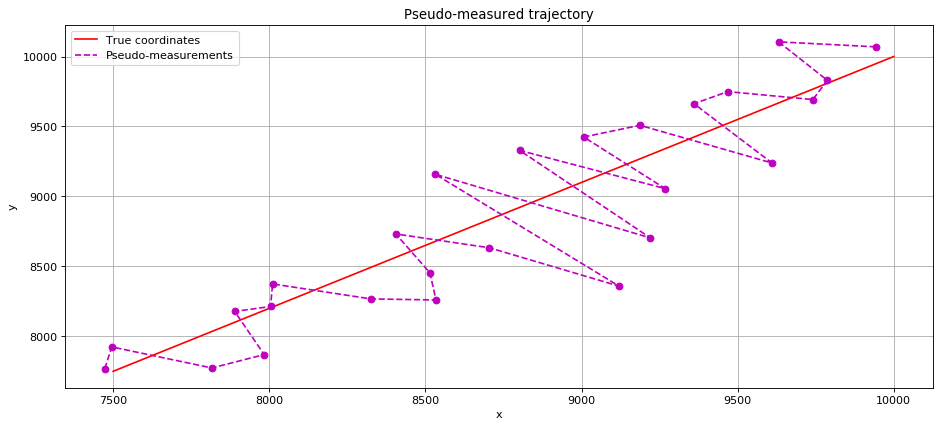

In [15]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(x, y, 'r-', label='True coordinates')
plt.plot(xpm, ypm, 'mo')
plt.plot(xpm, ypm, 'm--', label='Pseudo-measurements')
plt.title('Pseudo-measured trajectory')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Construction of a Kalman Filter function.

In [16]:
# Create a list of measurement vectors Zm
def create_z(xpm, ypm):
    N = len(xpm)
    return [np.array([[xpm[i]], [ypm[i]]]) for i in range(N)]

In [17]:
Zm = create_z(xpm, ypm)

In [18]:
# Create the transition matrix F and observation matrix H
F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

In [19]:
def create_R(Dm, bm, sigmaD, sigmab):
    # Creates a list of measurement error covariance matrices R
    R = [];
    for i in range(N):
        Ra = (np.sin(bm[i]) * sigmaD) ** 2 + (Dm[i] * np.cos(bm[i]) * sigmab) ** 2
        Rb = np.sin(bm[i]) * np.cos(bm[i]) * (sigmaD ** 2 - (Dm[i] * sigmab) ** 2)
        Rc = (np.cos(bm[i]) * sigmaD) ** 2 + (Dm[i] * np.sin(bm[i]) * sigmab) ** 2
        R.append(np.array([[Ra, Rb], [Rb, Rc]]))
    return R

In [20]:
# Create a list of measurement error covariance matrices R
R = create_R(Dm, bm, sigmaD, sigmab)

In [21]:
# Kalman Filter
def KalmanFilter(Zm, Xf0, P00, R, F, H, T):
    "returns Kalman filter estimates Xf and Xp (state vectors filtration and prediction) of given measurements Zm"
    N = len(Zm)
    Xp = []
    Xp.append(Xf0)
    Xf = []
    Xf.append(Xf0)
    Ht = np.transpose(H)
    Ft = np.transpose(F)
    I = np.eye(4)
    K = []
    Pp = []
    Pp.append(P00)
    Pf = []
    Pf.append(P00)
    Q = np.zeros((4, 4))
    for i in range(1, N):
        # prediction
        Xp.append(np.matmul(F, Xf[i - 1]))
        Pp.append(np.matmul(np.matmul(F, Pf[i - 1]), Ft) + Q)
        # filtration
        K.append(np.matmul(Pp[i], np.matmul(Ht, np.linalg.inv(np.matmul(np.matmul(H, Pp[i]), Ht) + R[i]))))
        Xf.append(Xp[i] + np.matmul(K[-1], (Zm[i] - np.matmul(H, Xp[i]))))
        Pf.append(np.matmul(I - np.matmul(K[-1], H), Pp[i]))
    return [Xf, Xp, K];

In [22]:
# set initial values
X0 = np.array([[40000], [-20], [40000], [-20]])
P00 = np.eye(4) * 10 ** 10;

In [23]:
[Xf, Xp, K] = KalmanFilter(Zm, X0, P00, R, F, H, T)

In [24]:
# transform X to Z and change format for more convinient plotting
def XtoZ(Xf, Xp):
    Zf = np.array([[Xf[i][0][0] for i in range(N)], [Xf[i][2][0] for i in range(N)]])
    Zp = np.array([[Xp[i][0][0] for i in range(N)], [Xp[i][2][0] for i in range(N)]])
    return [Zf, Zp]

In [25]:
[Zf, Zp] = XtoZ(Xf, Xp)

In [26]:
# Calculate D and b from Zp and Zf
def calc_D_b(Zf, Zp):
    Df = []
    Dp = []
    bf = []
    bp = []
    N = len(Zf[0])
    for i in range(N):
        Df.append((Zf[0][i]**2 + Zf[1][i]**2)**.5)
        Dp.append((Zp[0][i]**2 + Zp[1][i]**2)**.5)
        bf.append(atan(Zf[0][i]/(Zf[1][i])))
        bp.append(atan(Zp[0][i]/(Zp[1][i])))
    return [Df, Dp, bf, bp]

In [27]:
[Df, Dp, bf, bp] = calc_D_b(Zf, Zp)

## Visualisation

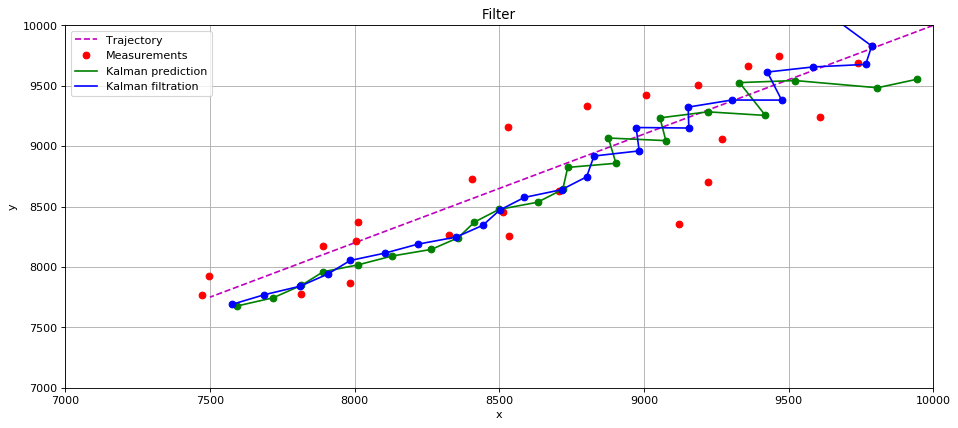

In [28]:
# Plot x-y
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(x, y, 'm--', label = "Trajectory")
plt.plot(xpm, ypm, 'ro', label = "Measurements")
plt.plot(Zp[0], Zp[1], 'go')
plt.plot(Zp[0][3:], Zp[1][3:], 'g-', label = "Kalman prediction")
plt.plot(Zf[0], Zf[1], 'bo')
plt.plot(Zf[0], Zf[1], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(7000, 10000)
plt.ylim(7000, 10000)
plt.show()

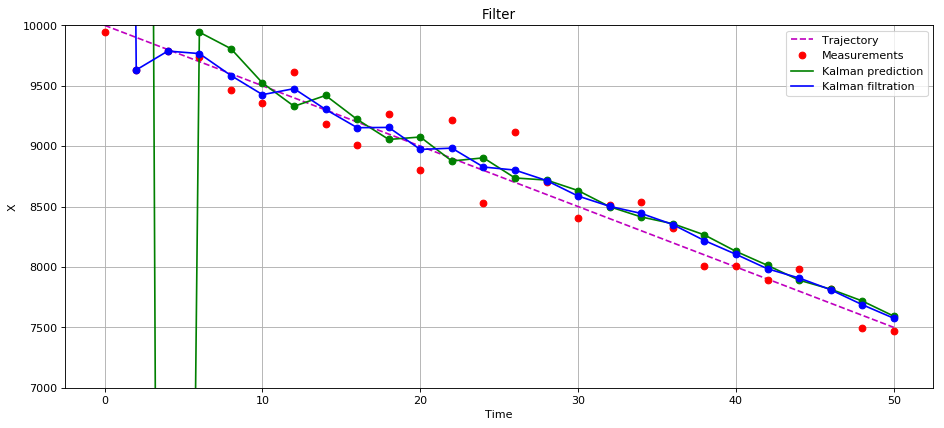

In [29]:
# Plot x
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, x, 'm--', label = "Trajectory")
plt.plot(Time, xpm, 'ro', label = "Measurements")
plt.plot(Time, Zp[0], 'g-', label = "Kalman prediction")
plt.plot(Time, Zp[0], 'go')
plt.plot(Time, Zf[0], 'b-', label = "Kalman filtration")
plt.plot(Time, Zf[0], 'bo')

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('Time')
plt.ylabel('X')
plt.ylim(7000, 10000)
plt.show()

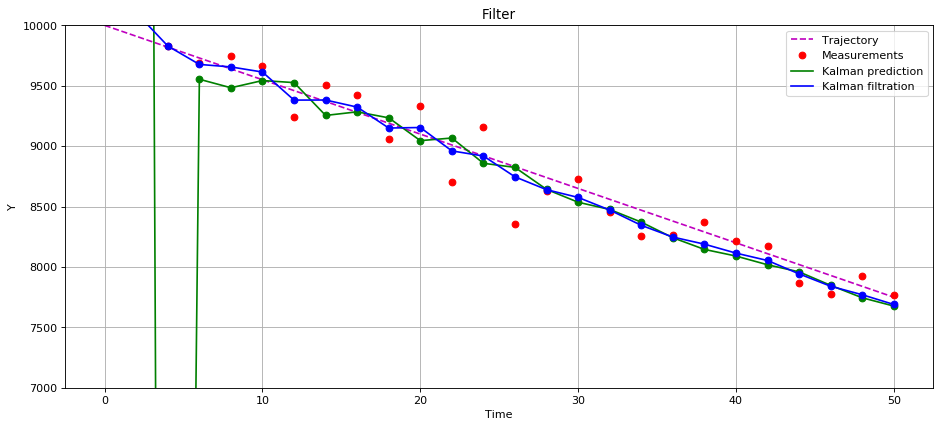

In [30]:
# Plot y
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, y, 'm--', label = "Trajectory")
plt.plot(Time, ypm, 'ro', label = "Measurements")
plt.plot(Time, Zp[1], 'g-', label = "Kalman prediction")
plt.plot(Time, Zp[1], 'go')
plt.plot(Time, Zf[1], 'b-', label = "Kalman filtration")
plt.plot(Time, Zf[1], 'bo')

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('Time')
plt.ylabel('Y')
plt.ylim(7000, 10000)
plt.show()

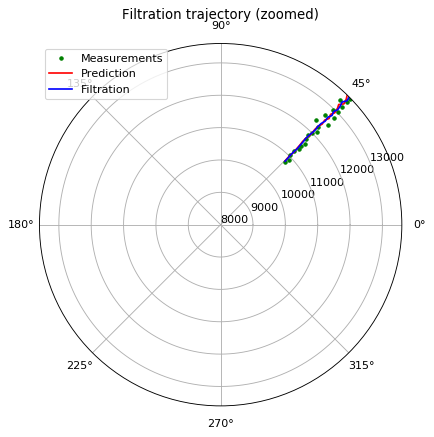

In [31]:
# Plot polar
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(bm, Dm, "g.", label='Measurements')
plt.polar(bp[3:], Dp[3:], "r-", label='Prediction')
plt.polar(bf[1:], Df[1:], "b-", label='Filtration')
plt.title('Filtration trajectory (zoomed)')
plt.legend()
plt.ylim(8000,13600)
plt.show()

In [32]:
# Error
def error(t, v):
    "returns error of estimation e of variable v"
    return round(sum((t - v) ** 2) / len(v) / len(v), 2) 

In [33]:
print('Error of Kalman prediction of D =', error(D, Dp), '; of b =', error(b, bp))
print('Error of Kalman filtration of D =', error(D, Df), '; of b =', error(b, bf))

Error of Kalman prediction of D = 5393606.74 ; of b = 0.0
Error of Kalman filtration of D = 2662731.32 ; of b = 0.0


## M = 500 runs and error of estimation calculation

In [34]:
# Errors
def errors_run(t, v):
    "returns errors of estimation e of variable v"
    return (t - v) ** 2

In [35]:
# M runs
M = 500
# Xfs = [] # store each Xf
# Xps = [] # store each Xp
ErrorRunDf = []
ErrorRunDp = []
ErrorRunbf = []
ErrorRunbp = []
Final_Error_Df = []
Final_Error_Dp = []
Final_Error_bf = []
Final_Error_bp = []
K0M = []
for i in range(M):
    [Dm, bm] = generate_measurements(N, sigmaD, sigmab)
    [xpm, ypm] = polar_to_cartesian(Dm, bm)
    Zm = create_z(xpm, ypm)
    [Xf, Xp, K_temp] = KalmanFilter(Zm, X0, P00, R, F, H, T)
    K0M.append(K_temp)
    # Xfs.append(Xf)
    # Xps.append(Xp)
    [Zf, Zp] = XtoZ(Xf, Xp)
    [Df, Dp, bf, bp] = calc_D_b(Zf, Zp)
    ErrorRunDf.append(errors_run(D, Df))
    ErrorRunDp.append(errors_run(D, Dp))
    ErrorRunbf.append(errors_run(b, bf))
    ErrorRunbp.append(errors_run(b, bp))

In [36]:
# Final Error Calculation
Final_Error_Df = (np.sum(ErrorRunDf, axis=0) / (M - 1)) ** .5
Final_Error_Dp = (np.sum(ErrorRunDp, axis=0) / (M - 1)) ** .5
Final_Error_bf = (np.sum(ErrorRunbf, axis=0) / (M - 1)) ** .5
Final_Error_bp = (np.sum(ErrorRunbp, axis=0) / (M - 1)) ** .5

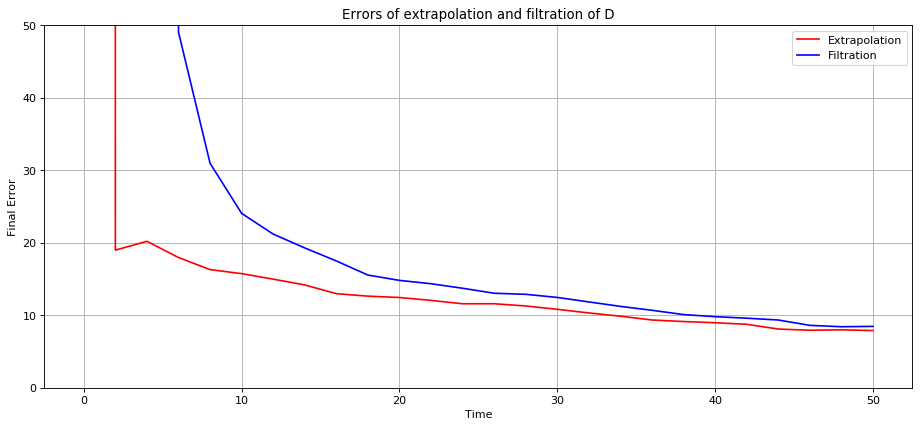

In [37]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, Final_Error_Dp, 'r-', label = "Extrapolation")
plt.plot(Time, Final_Error_Df, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of D')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0, 50)
plt.show()

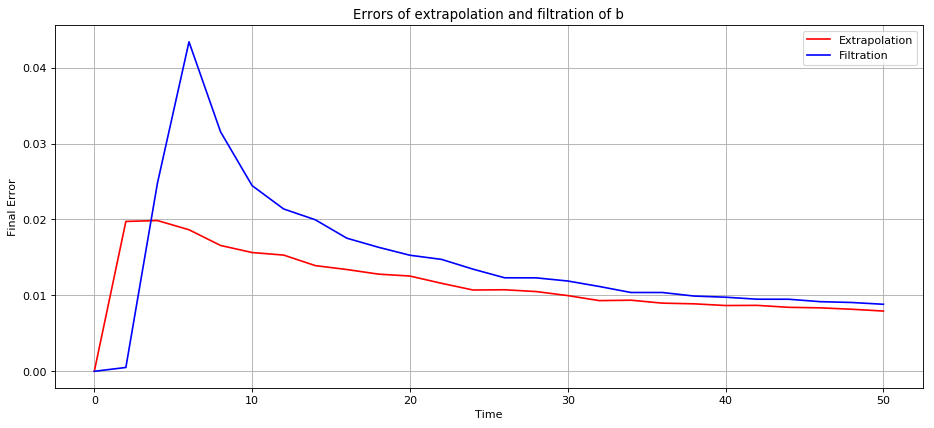

In [38]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, Final_Error_bp, 'r-', label = "Extrapolation")
plt.plot(Time, Final_Error_bf, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of b')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.show()

The errors defenetely decrease with time (exept b at first few steps, of course).

## Analysis of dependence of coordinate 𝑥 on azimuth 𝛽 

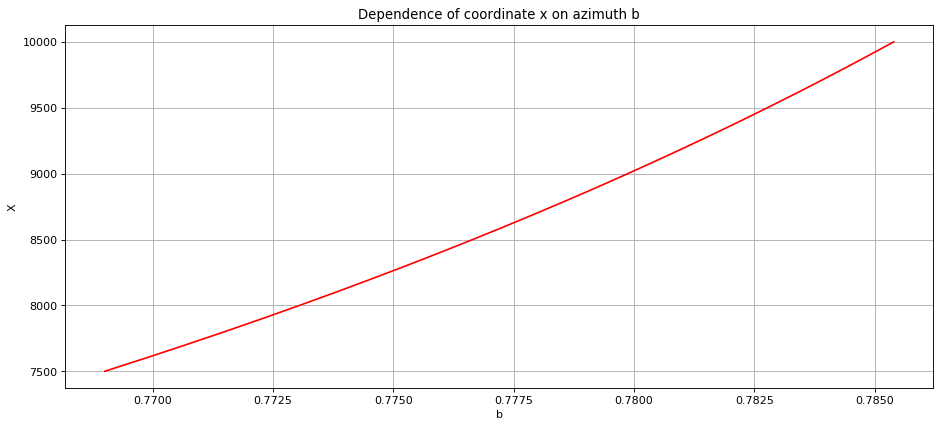

In [39]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(b, x, 'r-')

plt.grid()
plt.title('Dependence of coordinate x on azimuth b')
plt.xlabel('b')
plt.ylabel('X')
plt.show()

The dependency is:<br>
x = D * sin b<br>
However, in these conditions it is closer to linear. Range of b is small enough.<br>
It means that linearization errors are insignificant. 

## Condition number of covariance matrix 𝑅 over the observation interval

In [40]:
from numpy.linalg import eigvals
condition_number = []
for i in range(N):
    ev = eigvals(R[i])
    condition_number.append(ev[0]/ev[1] if (ev[0]>ev[1]) else ev[1]/ev[0])

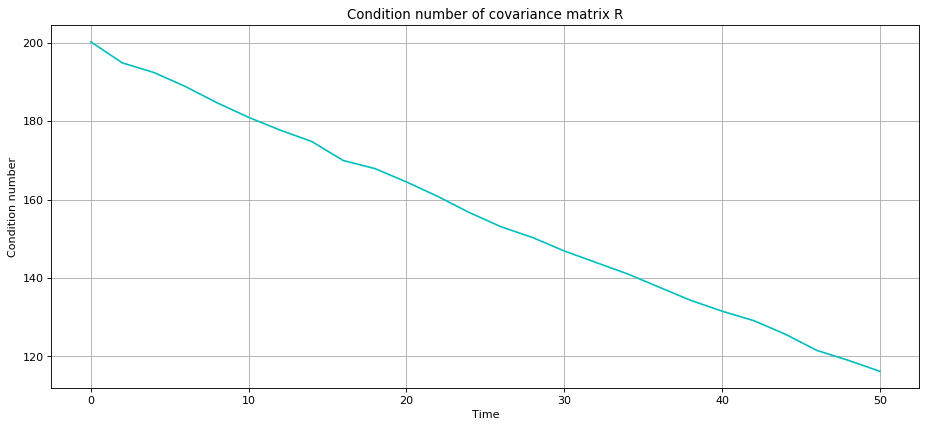

In [41]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, condition_number, 'c-')

plt.grid()
plt.title('Condition number of covariance matrix R')
plt.xlabel('Time')
plt.ylabel('Condition number')
plt.show()

Condition number decreases over time.<br>
If condition number close to 1, than matrix 𝑅 is well-conditioned. If condition number is relatively great, then matrix 𝑅 is ill-conditioned.<br>
So, matrix 𝑅 is a bit ill-conditioned. Estimation accuracy is a little bit decreased and filter may diverge.

## Filter gain K analysis

In [42]:
K0 = []
for i in range(N - 1):
    K0.append(K0M[0][i][0][0])

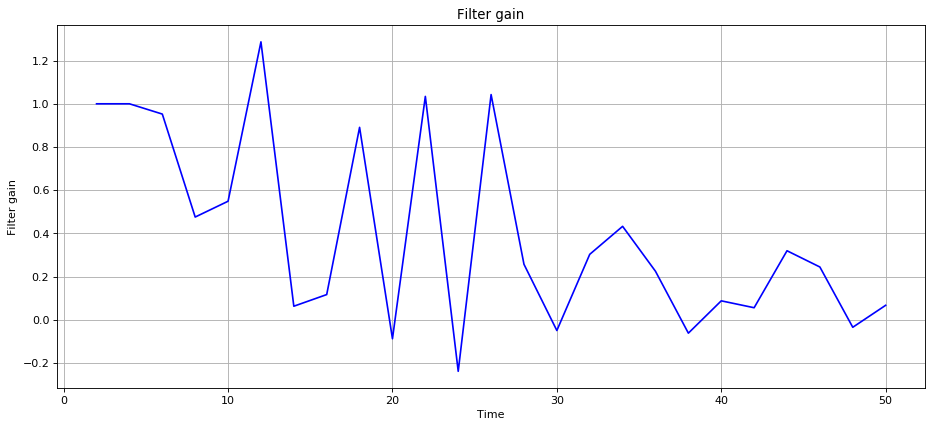

In [43]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time[1:], K0, 'b-')

plt.grid()
plt.title('Filter gain')
plt.xlabel('Time')
plt.ylabel('Filter gain')
plt.show()

There is a value of 𝐾(0,0), that does NOT belong to interval (0,1). It is negative. This is related to the fact that matrix 𝑅 depends on polar measurements that have errors

## New trajectory

## M = 500 runs and error of estimation calculation

In [44]:
[x,Vx,y,Vy] = generate_tr(3500/2**.5,-50,3500/2**.5,-45)

In [45]:
[D, b] = change_to_polar(x,y)
[Dm, bm] = generate_measurements(N, sigmaD, sigmab)
R = create_R(Dm, bm, sigmaD, sigmab)

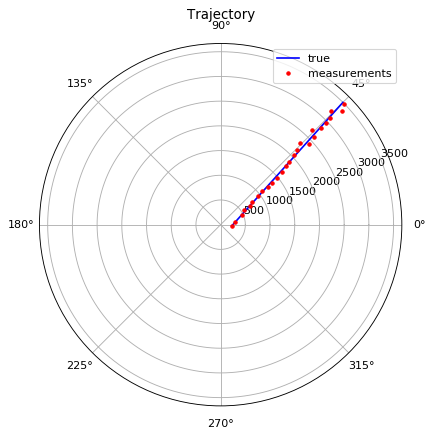

In [46]:
# Plot
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(b, D, "b-", label='true')
plt.polar(bm, Dm, "r.", label='measurements')
plt.title('Trajectory')
plt.legend()
plt.show()

Motion is at a quite close distance from an observer. 

In [47]:
# M runs
M = 500
# Xfs = [] # store each Xf
# Xps = [] # store each Xp
ErrorRunDf = []
ErrorRunDp = []
ErrorRunbf = []
ErrorRunbp = []
Final_Error_Df = []
Final_Error_Dp = []
Final_Error_bf = []
Final_Error_bp = []
K0M = []
for i in range(M):
    [Dm, bm] = generate_measurements(N, sigmaD, sigmab)
    [xpm, ypm] = polar_to_cartesian(Dm, bm)
    Zm = create_z(xpm, ypm)
    [Xf, Xp, K_temp] = KalmanFilter(Zm, X0, P00, R, F, H, T)
    K0M.append(K_temp)
    # Xfs.append(Xf)
    # Xps.append(Xp)
    [Zf, Zp] = XtoZ(Xf, Xp)
    [Df, Dp, bf, bp] = calc_D_b(Zf, Zp)
    ErrorRunDf.append(errors_run(D, Df))
    ErrorRunDp.append(errors_run(D, Dp))
    ErrorRunbf.append(errors_run(b, bf))
    ErrorRunbp.append(errors_run(b, bp))

In [48]:
# Final Error Calculation
Final_Error_Df = (np.sum(ErrorRunDf, axis=0) / (M - 1)) ** .5
Final_Error_Dp = (np.sum(ErrorRunDp, axis=0) / (M - 1)) ** .5
Final_Error_bf = (np.sum(ErrorRunbf, axis=0) / (M - 1)) ** .5
Final_Error_bp = (np.sum(ErrorRunbp, axis=0) / (M - 1)) ** .5

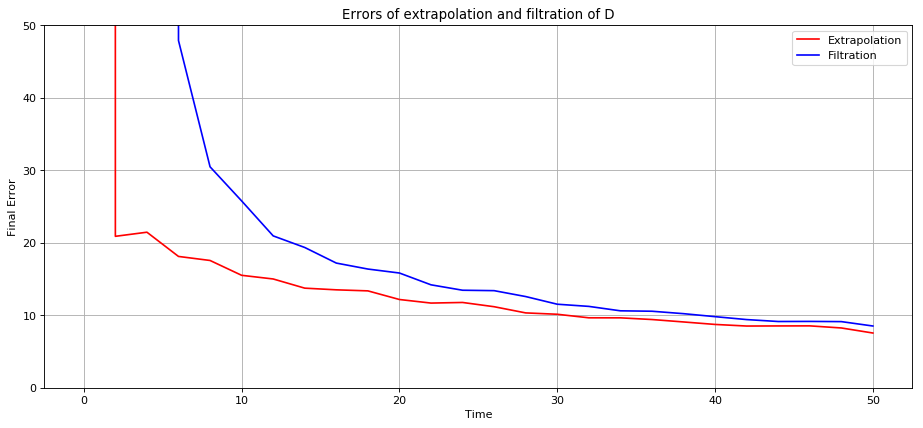

In [49]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, Final_Error_Df, 'r-', label = "Extrapolation")
plt.plot(Time, Final_Error_Dp, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of D')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0, 50)
plt.show()

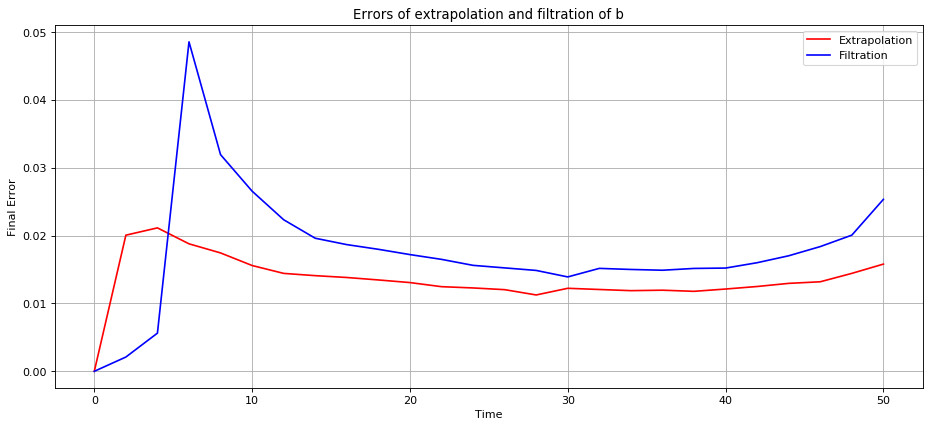

In [50]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, Final_Error_bf, 'r-', label = "Extrapolation")
plt.plot(Time, Final_Error_bp, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of b')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.show()

The errors decrease with time, but errors of b then increase.

## Analysis of dependence of coordinate 𝑥 on azimuth 𝛽 

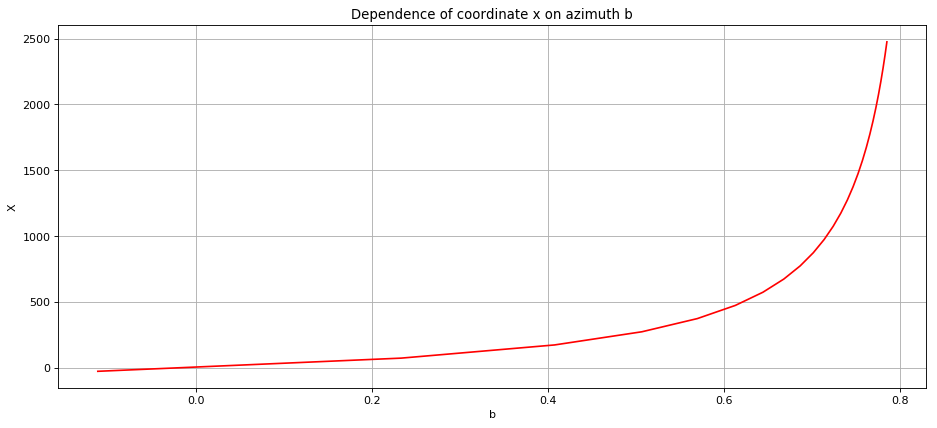

In [51]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(b, x, 'r-')

plt.grid()
plt.title('Dependence of coordinate x on azimuth b')
plt.xlabel('b')
plt.ylabel('X')
plt.show()

Range of b is enough to see a non-linear dependency.<br>
It means that linearization errors are significant. 

## Condition number of covariance matrix 𝑅 over the observation interval

In [52]:
from numpy.linalg import eigvals
condition_number = []
for i in range(N):
    ev = eigvals(R[i])
    condition_number.append(ev[0]/ev[1] if (ev[0]>ev[1]) else ev[1]/ev[0])

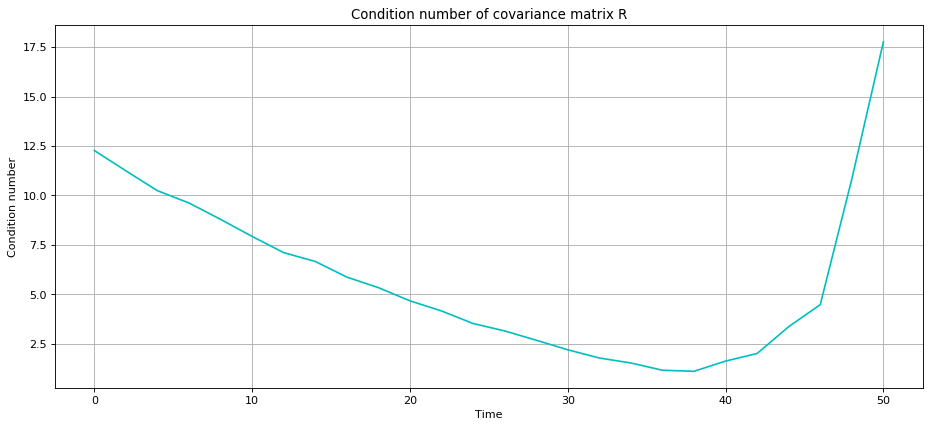

In [53]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, condition_number, 'c-')

plt.grid()
plt.title('Condition number of covariance matrix R')
plt.xlabel('Time')
plt.ylabel('Condition number')
plt.show()

Condition number behaves different in this case: decreases first, then increases.<br>
It is close to 1, which means matrix R is well-conditioned.<br>
So, estimation accuracy is NOT decreased.

## New new trajectory

In [54]:
sigmaD = 50
sigmab = 0.0015

## M = 500 runs and error of estimation calculation

In [55]:
[x,Vx,y,Vy] = generate_tr(3500/2**.5,-50,3500/2**.5,-45)

In [56]:
[D, b] = change_to_polar(x,y)
[Dm, bm] = generate_measurements(N, sigmaD, sigmab)
R = create_R(Dm, bm, sigmaD, sigmab)

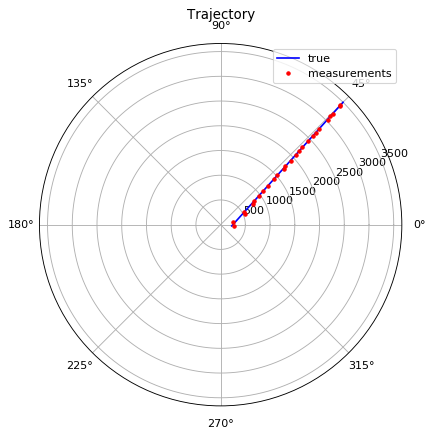

In [57]:
# Plot
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(b, D, "b-", label='true')
plt.polar(bm, Dm, "r.", label='measurements')
plt.title('Trajectory')
plt.legend()
plt.show()

Motion is at a quite close distance from an observer. 

In [58]:
# M runs
M = 500
# Xfs = [] # store each Xf
# Xps = [] # store each Xp
ErrorRunDf = []
ErrorRunDp = []
ErrorRunbf = []
ErrorRunbp = []
Final_Error_Df = []
Final_Error_Dp = []
Final_Error_bf = []
Final_Error_bp = []
K0M = []
for i in range(M):
    [Dm, bm] = generate_measurements(N, sigmaD, sigmab)
    [xpm, ypm] = polar_to_cartesian(Dm, bm)
    Zm = create_z(xpm, ypm)
    [Xf, Xp, K_temp] = KalmanFilter(Zm, X0, P00, R, F, H, T)
    K0M.append(K_temp)
    # Xfs.append(Xf)
    # Xps.append(Xp)
    [Zf, Zp] = XtoZ(Xf, Xp)
    [Df, Dp, bf, bp] = calc_D_b(Zf, Zp)
    ErrorRunDf.append(errors_run(D, Df))
    ErrorRunDp.append(errors_run(D, Dp))
    ErrorRunbf.append(errors_run(b, bf))
    ErrorRunbp.append(errors_run(b, bp))

In [59]:
# Final Error Calculation
Final_Error_Df = (np.sum(ErrorRunDf, axis=0) / (M - 1)) ** .5
Final_Error_Dp = (np.sum(ErrorRunDp, axis=0) / (M - 1)) ** .5
Final_Error_bf = (np.sum(ErrorRunbf, axis=0) / (M - 1)) ** .5
Final_Error_bp = (np.sum(ErrorRunbp, axis=0) / (M - 1)) ** .5

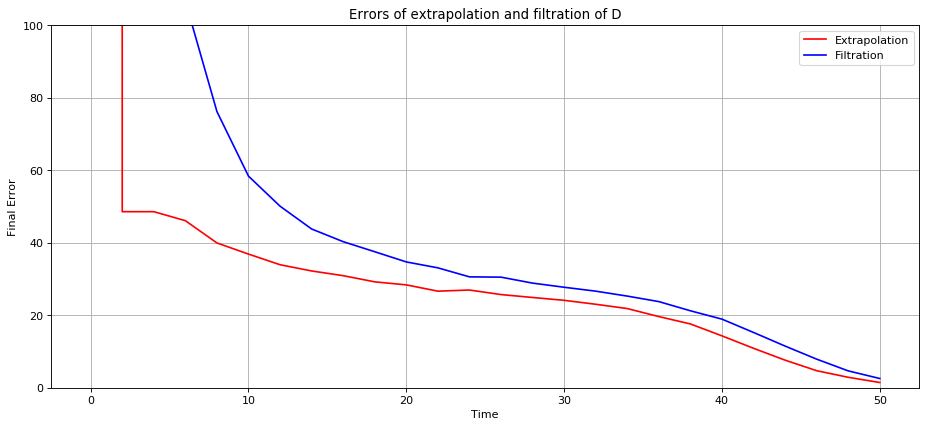

In [60]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, Final_Error_Df, 'r-', label = "Extrapolation")
plt.plot(Time, Final_Error_Dp, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of D')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0, 100)
plt.show()

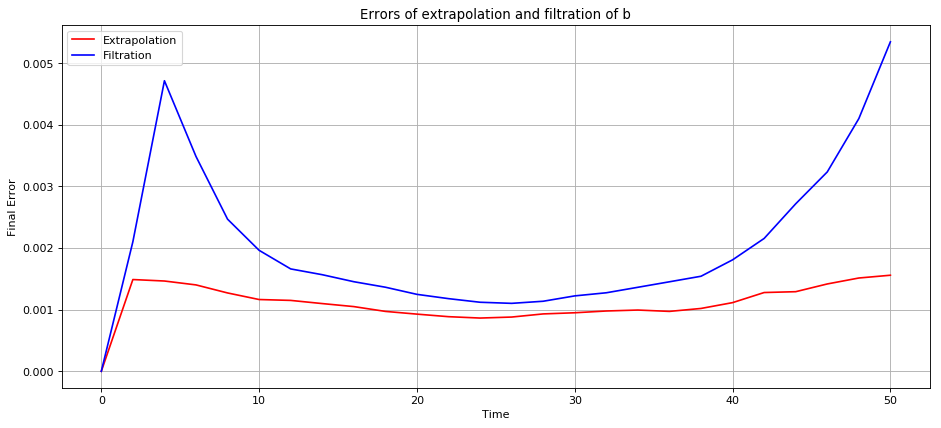

In [61]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, Final_Error_bf, 'r-', label = "Extrapolation")
plt.plot(Time, Final_Error_bp, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of b')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.show()

Errors of D are much higher most of the time, than in previous cases. However, it becomes even in the end.
Errors of b decrease at first, but then increase.

## Analysis of dependence of coordinate 𝑥 on azimuth 𝛽 

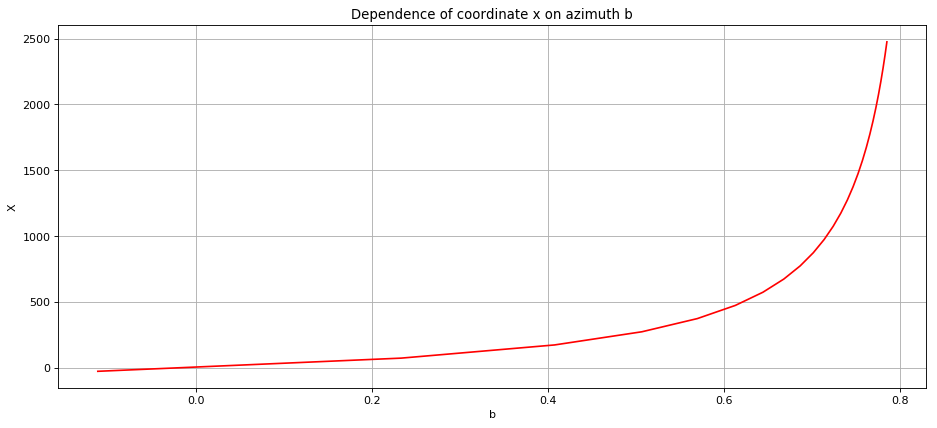

In [62]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(b, x, 'r-')

plt.grid()
plt.title('Dependence of coordinate x on azimuth b')
plt.xlabel('b')
plt.ylabel('X')
plt.show()

Same as in the 2nd case.

## Condition number of covariance matrix 𝑅 over the observation interval

In [63]:
from numpy.linalg import eigvals
condition_number = []
for i in range(N):
    ev = eigvals(R[i])
    condition_number.append(ev[0]/ev[1] if (ev[0]>ev[1]) else ev[1]/ev[0])

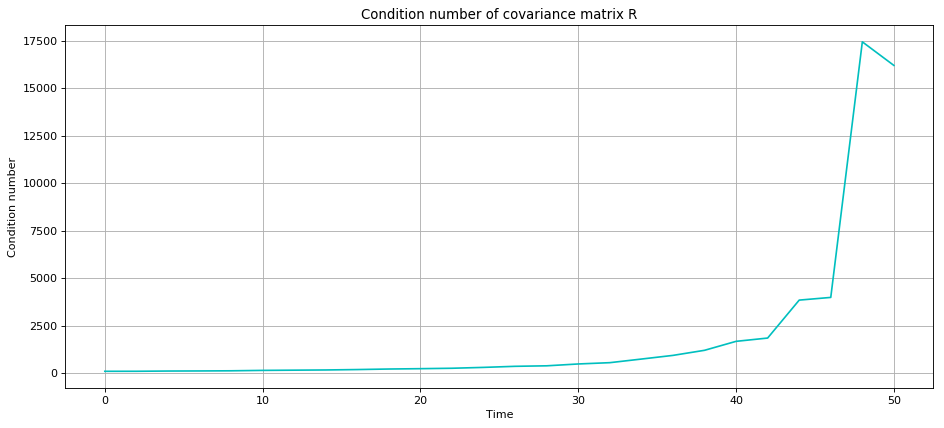

In [64]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, condition_number, 'c-')

plt.grid()
plt.title('Condition number of covariance matrix R')
plt.xlabel('Time')
plt.ylabel('Condition number')
plt.show()

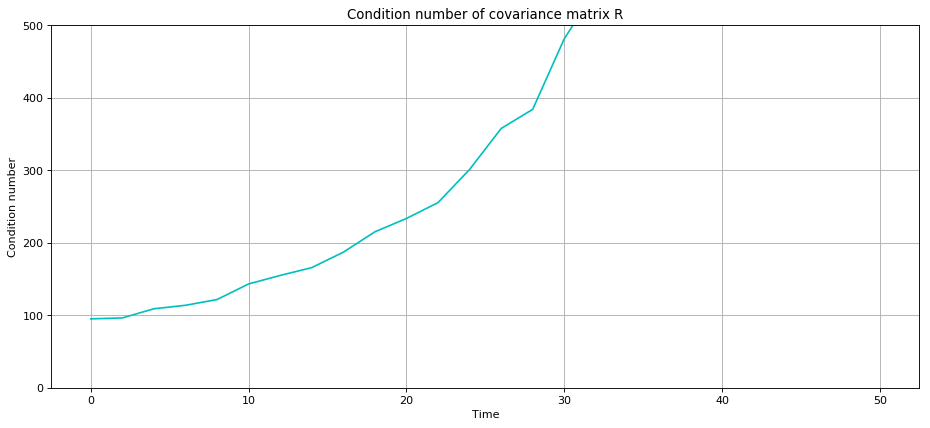

In [65]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, condition_number, 'c-')

plt.grid()
plt.title('Condition number of covariance matrix R')
plt.xlabel('Time')
plt.ylabel('Condition number')
plt.ylim(0,500)
plt.show()

Now condition number only increases.<br>
It is NOT close to 1, which means matrix R is NOT well-conditioned.<br>
So, estimation accuracy is decreased.

## Conclusion
Navigation system may become blind when object is close to observer. This is related with ill-conditioned covariance matrix R. Linearization errors become very significant.<br>
Linearization error and ill-conditioning are both a problem. In our task ill-conditioning appeared to be a bigger deal, and had greater influence. An extra-observer in a distant place could help to overcome this ill-conditioned problem.<br>
Knowing detected difficulties of practical Kalman filter implementation related with instability zone of a tracking filter are very important to prevent collisions and for other safety issues. It is good to know conditions under which navigation system may become blind and filter diverges.